# Modelo de Gumbel

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import root_mean_squared_error 
import scipy
import seaborn as sns

In [2]:
# Dados de entrada
path = "C:\\ENS\\Hidrologia"
dados = pd.read_excel(path+'\\Dados_ANA.xlsx')
dados = dados.set_index('Data') 
#dados.info()

In [3]:
# Separando máximas anuais 
dados = dados.groupby(dados.index.year).max()   

In [4]:
dados['Ordem i'] = range(1, len(dados['Vazão'])+1)
dados['Q ord (m³/s)'] = sorted(dados['Vazão'], reverse=True)
dados['Tr empírico (anos)'] = (len(dados['Vazão'])+1)/dados['Ordem i'] 
dados.head()

,Vazão,ln(Vazão),Ordem i,Q ord (m³/s),Tr empírico (anos)
Data,,,,,
1980,502.7077,6.220009,1,1077.3507,37.000000
1981,580.6066,6.364073,2,971.6529,18.500000
1982,803.3920,6.688843,3,962.8472,12.333333
1983,962.8472,6.869895,4,930.0946,9.250000
1984,500.9865,6.216579,5,887.0893,7.400000


In [5]:
def Gumbel(alfa, beta, Kp):
    return alfa + (beta*Kp) 

alfa = dados['Vazão'].mean() - (0.45*dados['Vazão'].std())
beta = 0.7797*dados['Vazão'].std()

Tr = np.exp(np.linspace(np.log(1.001), np.log(100), 300))
modelo = pd.DataFrame(data=Tr, columns=['Tr (anos)'])
modelo['Kp'] = -np.log(-np.log(1-(1/modelo['Tr (anos)'])))
modelo['Q Gumbel (m³/s)'] = Gumbel(alfa, beta, modelo['Kp'])
modelo.head() 

,Tr (anos),Kp,Q Gumbel (m³/s)
0,1.001000,-1.932789,173.068862
1,1.016533,-1.415557,263.921724
2,1.032308,-1.242497,294.320120
3,1.048327,-1.123945,315.143968
4,1.064594,-1.030413,331.572961


In [6]:
# Intervalo de confiança
modelo['aux'] = (1+(1.14*modelo['Kp'])+(1.1*modelo['Kp']**2))**(1/2)
modelo['EP'] = modelo['aux']*modelo['Q Gumbel (m³/s)'].std()/(len(modelo['aux'])**(1/2))
modelo['Limite inf'] = modelo['Q Gumbel (m³/s)']-(1.96*modelo['EP'])
modelo['Limite sup'] = modelo['Q Gumbel (m³/s)']+(1.96*modelo['EP']) 

In [7]:
# RMSE
Kp = [-np.log(-np.log(1-(1/i))) for i in dados['Tr empírico (anos)']]
y_pred = [Gumbel(alfa, beta, i) for i in Kp]
print('RMSE = '+str(root_mean_squared_error(dados['Q ord (m³/s)'], y_pred)))

RMSE = 52.158953192606894


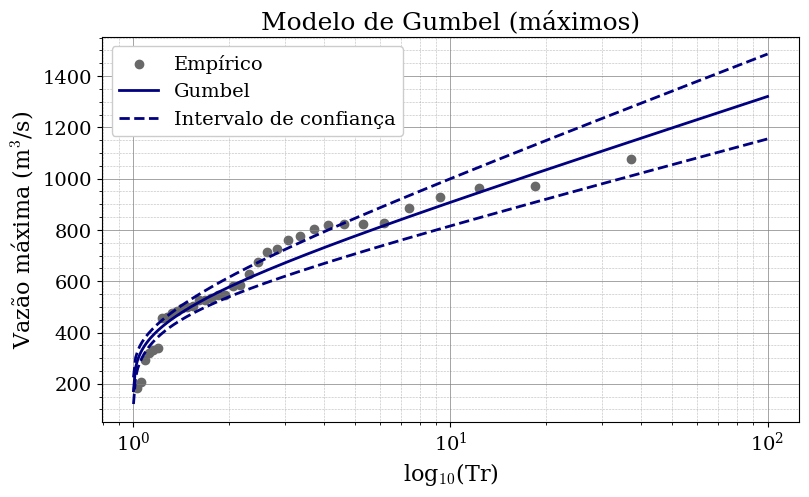

In [9]:
fig,ax = plt.subplots(figsize=(9,5)) 
plt.rcParams['font.family'] = 'serif'
plt.rcParams['mathtext.fontset'] = 'cm'  

ax.scatter(dados['Tr empírico (anos)'], 
           dados['Q ord (m³/s)'],
           color='dimgray',
           label = 'Empírico')

ax.plot(modelo['Tr (anos)'], 
        modelo['Q Gumbel (m³/s)'], 
        color='navy', 
        linewidth=2,
        label = 'Gumbel') 

ax.plot(modelo['Tr (anos)'], 
        modelo['Limite inf'], 
        color='navy', 
        linewidth=2,
        linestyle='--') 
ax.plot(modelo['Tr (anos)'], 
        modelo['Limite sup'], 
        color='navy', 
        linewidth=2,
        linestyle='--',
        label = 'Intervalo de confiança') 


plt.xscale('log') 
plt.title('Modelo de Gumbel (máximos)', size = 18)
plt.xlabel(r'log$_{10}$(Tr)', size = 16)
plt.ylabel(r'Vazão máxima (m$^3$/s)', size = 16)
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
ax.grid(True,
        which='major', 
        color='gray', 
        linestyle='-',
        linewidth=0.5)
ax.grid(True,
        which='minor', 
        color='gray', 
        linestyle=':',
        linewidth=0.4)
ax.minorticks_on()
plt.legend(fontsize=14, framealpha=1) 
plt.savefig(path+'\\gumbel_max.png', bbox_inches='tight') 

# Máximas anuais
## Hidrograma

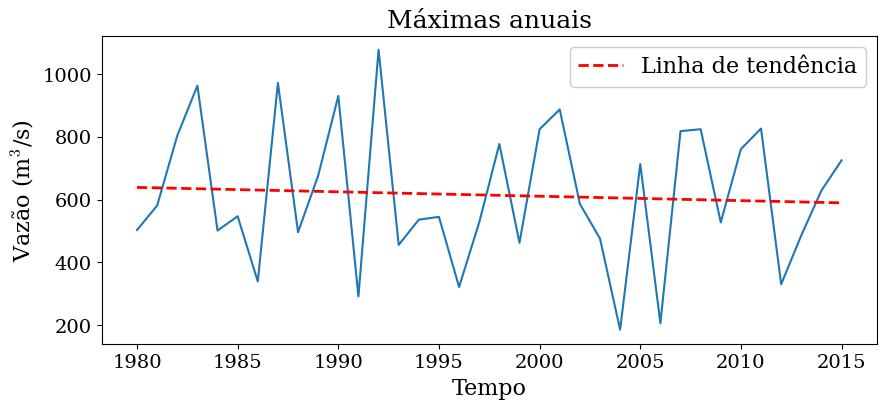

In [10]:
# Linha de tendência 
def f(x,a,b):
    return a*x + b
    
x = dados.index
y = dados['Vazão']
guess = [1, 1] # valores iniciais de a & b 
params, params_covariance = scipy.optimize.curve_fit(f, x, y, guess)
a = params[0]
b = params[1]

# Higrograma 
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(dados['Vazão'])
ax.plot(x, f(x, a, b),
        linestyle='--', 
        linewidth=2,
        color='red',
        label='Linha de tendência')
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.title('Máximas anuais', size = 18)
plt.xlabel('Tempo', fontsize=16)
plt.ylabel('Vazão (m$^3$/s)', fontsize=16)
plt.legend(fontsize=16, framealpha=1)
plt.savefig(path+'\\maximas.png', bbox_inches='tight')

## Histograma

In [11]:
# Sturges
n = len(dados['Vazão'])
k = 1 + (3.33*np.log10(n)) 
print('k = ', k) 

k =  6.182487327555067


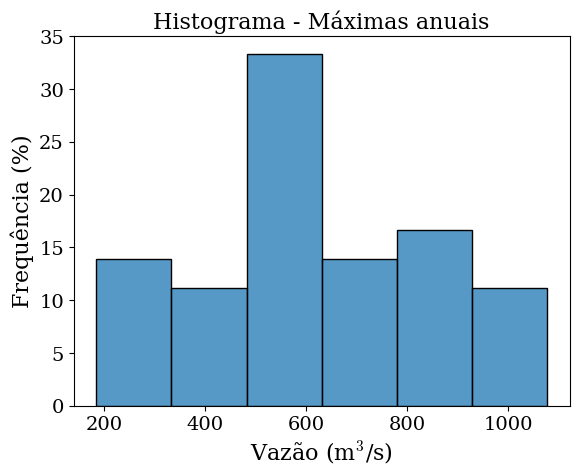

In [12]:
# Histograma 
fig, ax = plt.subplots() 
data = dados['Vazão']
num_bins = 6 # k arredondado
counts, bin_edges = np.histogram(data, bins=num_bins)

sns.histplot(data=dados, 
             x=dados['Vazão'], 
             stat="percent",
             bins=bin_edges) 

plt.title('Histograma - Máximas anuais', fontsize=16) 
plt.xlabel('Vazão (m$^3$/s)', fontsize=16) 
plt.ylabel('Frequência (%)', fontsize=16) 
plt.savefig(path+'\\hist_max.png', bbox_inches='tight')